# Flow Matching: Learning to Transform Noise into Data

Every image you've ever seen from Stable Diffusion, Midjourney, or DALL-E started as pure random noise. A **generative model** learned to transform that noise into coherent images. In this notebook, we'll build one from scratch.

We'll use **flow matching** - a simple approach that has become the foundation for state-of-the-art image generation. By the end, you'll have a model that can generate handwritten digits from nothing but Gaussian noise.

## The Problem We're Solving

Here's the setup:

- We have training data $x \sim p_{\text{data}}(x)$ (real MNIST digits)
- We want to sample *new* images from $p_{\text{data}}$
- But we don't know $p_{\text{data}}$ explicitly - we only have examples

The strategy: learn a **transformation** from a simple distribution (Gaussian noise) to our complex data distribution. If we can learn this transformation, we can generate new samples by:
1. Sample noise $z \sim \mathcal{N}(0, I)$
2. Apply our learned transformation
3. Out comes a realistic image!

## Why Flow Matching?

Several approaches exist for generative modeling:

| Approach | Core Idea | Challenge |
|----------|-----------|----------|
| **GANs** | Generator fools discriminator | Training instability, mode collapse |
| **VAEs** | Encode/decode through latent space | Blurry outputs, approximate posteriors |
| **DDPM** | Gradually denoise over many steps | Stochastic, slow sampling, complex math |
| **Flow Matching** | Learn straight paths from noise to data | Simple, fast, deterministic |

Flow matching has become the preferred choice because:

1. **Simpler mathematics** - no stochastic differential equations required
2. **Faster sampling** - straight paths require fewer integration steps
3. **Same training objective** works for any architecture
4. **State-of-the-art results** - used in Stable Diffusion 3, Flux, and more

## The Mathematical Framework

### Probability Paths: The Core Intuition

Imagine two probability distributions:
- $p_0$: The data distribution (complex, what we want to sample from)
- $p_1$: A simple distribution (standard Gaussian, easy to sample)

Flow matching constructs a **continuous path of distributions** $p_t$ that smoothly transitions between them:

$$p_0 \xrightarrow{t=0 \to 1} p_1$$

The key insight: if we can describe how *individual samples* move along this path, we can:
1. **Train**: Learn the "velocity" of samples at each point
2. **Generate**: Start from $p_1$ (noise) and follow velocities backward to $p_0$ (data)

### Linear Interpolation: The Simplest Path

How do we connect a data point $x_0$ to a noise sample $x_1$? The simplest choice is a straight line:

$$x_t = (1-t) \cdot x_0 + t \cdot x_1$$

Let's verify this gives us what we want:

| $t$ | $x_t$ | Description |
|-----|-------|-------------|
| 0 | $(1-0)x_0 + 0 \cdot x_1 = x_0$ | Pure data |
| 0.5 | $0.5 \cdot x_0 + 0.5 \cdot x_1$ | Half data, half noise |
| 1 | $0 \cdot x_0 + 1 \cdot x_1 = x_1$ | Pure noise |

Perfect. As $t$ goes from 0 to 1, we trace a straight line from the data point to the noise sample.

(This linear path is sometimes called **rectified flow** or **optimal transport** flow, because straight lines are the shortest paths between points.)

### The Velocity Field

The **velocity** tells us how $x_t$ changes as $t$ increases. Let's derive it:

$$v = \frac{dx_t}{dt} = \frac{d}{dt}\left[(1-t) \cdot x_0 + t \cdot x_1\right]$$

Taking the derivative term by term:

$$v = \frac{d}{dt}[(1-t)] \cdot x_0 + \frac{d}{dt}[t] \cdot x_1 = -x_0 + x_1 = x_1 - x_0$$

This result is remarkable: **the velocity is constant**! It doesn't depend on $t$ at all.

Why does this matter?
- Each sample travels in a perfectly straight line
- The velocity is simply the direction from data to noise
- No curved paths, no acceleration - just constant motion

### The Neural Network's Job

We train a neural network $v_\theta(x_t, t)$ to predict the velocity given:
- $x_t$: The current "noised" sample (a blend of data and noise)
- $t$: The current timestep

The training loss is straightforward MSE:

$$\mathcal{L} = \mathbb{E}_{x_0 \sim p_{\text{data}}, \, x_1 \sim \mathcal{N}(0,I), \, t \sim U[0,1]}\left[\|v_\theta(x_t, t) - (x_1 - x_0)\|^2\right]$$

In words: sample data, sample noise, sample timestep, compute the interpolation $x_t$, predict velocity, compare to true velocity $x_1 - x_0$.

### Generating Samples: Solving the ODE

Once trained, generation is an **ordinary differential equation** (ODE):

$$\frac{dx_t}{dt} = v_\theta(x_t, t)$$

We start at $t=1$ with pure noise $x_1 \sim \mathcal{N}(0, I)$ and integrate *backward* to $t=0$:

$$x_0 = x_1 - \int_1^0 v_\theta(x_t, t) \, dt = x_1 + \int_0^1 v_\theta(x_t, t) \, dt$$

In practice, we use **Euler integration**:

$$x_{t-\Delta t} = x_t - \Delta t \cdot v_\theta(x_t, t)$$

Starting at $t=1$, we take small steps backward until we reach $t=0$.

### Key Equations at a Glance

| Concept | Equation | What It Does |
|---------|----------|-------------|
| **Interpolation** | $x_t = (1-t)x_0 + tx_1$ | Creates path from data to noise |
| **Velocity** | $v = x_1 - x_0$ | Direction of travel (constant!) |
| **Training Loss** | $\mathcal{L} = \|v_\theta(x_t, t) - v\|^2$ | MSE between predicted and true velocity |
| **Sampling ODE** | $\frac{dx}{dt} = v_\theta(x, t)$ | Defines the generation dynamics |
| **Euler Step** | $x_{t-\Delta t} = x_t - \Delta t \cdot v_\theta$ | Discrete approximation for sampling |

Now let's implement this.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Auto-reload modules during development
%load_ext autoreload
%autoreload 2

# Set up device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 1: The Data Distribution

We'll use MNIST - 28×28 grayscale handwritten digits. It's ideal for learning:
- Small images (784 pixels) = fast training
- Simple enough to verify visually
- Complex enough to be interesting (10 digit classes, varying styles)

**Important preprocessing**: We normalize pixels to $[-1, 1]$ instead of $[0, 1]$. Why? Our noise distribution $\mathcal{N}(0, I)$ is centered at zero with values typically in $[-3, 3]$. Centering our data similarly makes the interpolation path more balanced.

In [2]:
# Transform: convert to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Maps [0,1] to [-1,1]
])

# Download and load MNIST
train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,  # Set to 0 for MPS compatibility
    drop_last=True
)

print(f"Dataset size: {len(train_dataset):,} images")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Pixel range: [{train_dataset[0][0].min():.1f}, {train_dataset[0][0].max():.1f}]")

Dataset size: 60,000 images
Batches per epoch: 468
Image shape: torch.Size([1, 28, 28])
Pixel range: [-1.0, 1.0]


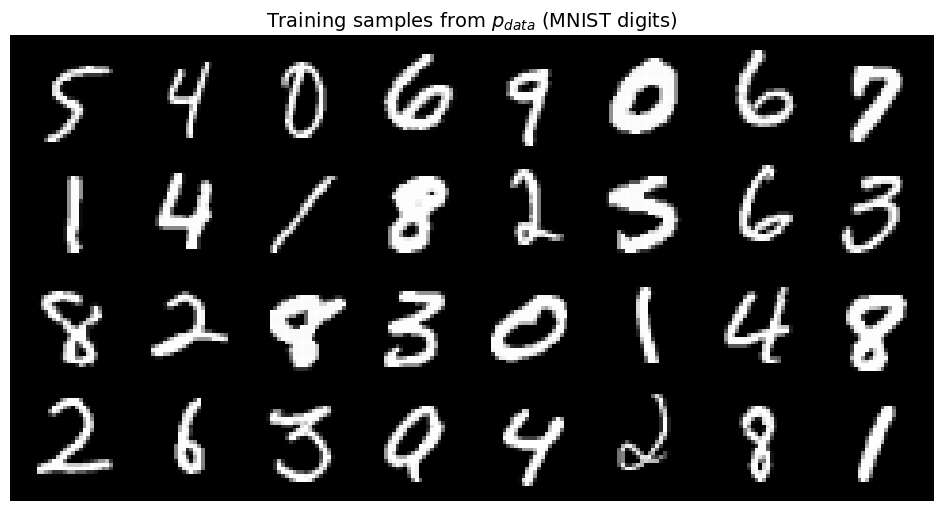

In [3]:
# Visualize some training samples
def show_images(images, nrow=8, title=""):
    """Display a grid of images."""
    # Denormalize from [-1, 1] to [0, 1]
    images = (images + 1) / 2
    images = images.clamp(0, 1)
    
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(12, 12 * grid.shape[1] / grid.shape[2]))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14)
    plt.show()

# Get a batch and visualize
sample_batch, _ = next(iter(train_loader))
show_images(sample_batch[:32], title="Training samples from $p_{data}$ (MNIST digits)")

## Step 2: The Forward Process (Data → Noise)

Let's implement and visualize the interpolation path from data to noise.

### The Interpolation Formula

For a data point $x_0$ and noise sample $x_1 \sim \mathcal{N}(0, I)$:

$$x_t = (1-t) \cdot x_0 + t \cdot x_1$$

### Geometric Picture

Think of each image as a point in 784-dimensional space (one dimension per pixel):
- $x_0$ lives on the "data manifold" - the region where realistic digits reside
- $x_1$ is a random point in space (Gaussian noise spreads throughout)
- $x_t$ traces a straight line between them

During training, we'll show the network samples $x_t$ at random timesteps and ask it to predict which direction leads toward noise.

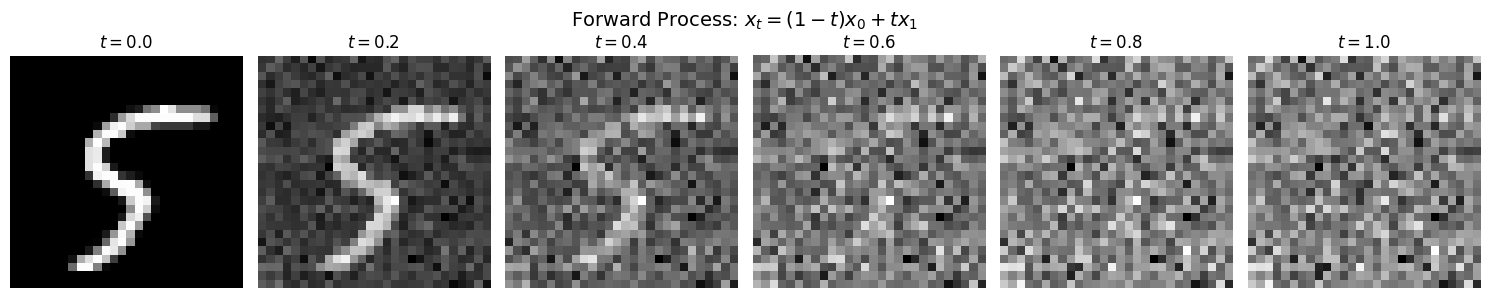


Watch how the digit structure gradually dissolves into noise.
Our model will learn to reverse this process.


In [4]:
from from_noise_to_images.flow import FlowMatching

flow = FlowMatching()

# Take one image and show its path to noise
x_0 = sample_batch[0:1]  # Shape: (1, 1, 28, 28)
x_1 = torch.randn_like(x_0)  # Sample noise ~ N(0, I)

# Show interpolation at different timesteps
timesteps = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
interpolated = []

for t in timesteps:
    t_tensor = torch.tensor([t])
    x_t, velocity = flow.forward_process(x_0, x_1, t_tensor)
    interpolated.append(x_t)

# Visualize
fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 3))
for i, (ax, t) in enumerate(zip(axes, timesteps)):
    img = (interpolated[i][0, 0] + 1) / 2  # Denormalize
    ax.imshow(img.numpy(), cmap='gray')
    ax.set_title(f'$t = {t}$', fontsize=12)
    ax.axis('off')
    
    # Add equation annotation
    if t == 0.0:
        ax.set_xlabel('$x_0$ (data)', fontsize=10)
    elif t == 1.0:
        ax.set_xlabel('$x_1$ (noise)', fontsize=10)
    elif t == 0.5:
        ax.set_xlabel('$0.5 x_0 + 0.5 x_1$', fontsize=10)

plt.suptitle('Forward Process: $x_t = (1-t) x_0 + t x_1$', fontsize=14)
plt.tight_layout()
plt.show()

print("\nWatch how the digit structure gradually dissolves into noise.")
print("Our model will learn to reverse this process.")

## Step 3: Understanding the Velocity Field

### Deriving the Velocity

The velocity is the time derivative of our interpolation:

$$v = \frac{dx_t}{dt} = \frac{d}{dt}\left[(1-t) x_0 + t x_1\right]$$

Let's work through this carefully:

$$v = \frac{d}{dt}[(1-t)] \cdot x_0 + (1-t) \cdot \frac{d}{dt}[x_0] + \frac{d}{dt}[t] \cdot x_1 + t \cdot \frac{d}{dt}[x_1]$$

Since $x_0$ and $x_1$ are constants (they don't depend on $t$):

$$v = (-1) \cdot x_0 + 0 + (1) \cdot x_1 + 0 = x_1 - x_0$$

### The Key Property: Constant Velocity

Notice that $v = x_1 - x_0$ has no $t$ in it. This means:

| Property | Implication |
|----------|-------------|
| Velocity is constant | Samples travel in straight lines |
| Same velocity at all $t$ | No acceleration, no curved paths |
| $v = x_1 - x_0$ | Velocity encodes the displacement from data to noise |

### What Does the Velocity Look Like?

Since $v = x_1 - x_0$ (pixel-wise subtraction):
- Where noise is brighter than data ($x_1 > x_0$): positive velocity (pixel brightens)
- Where noise is darker than data ($x_1 < x_0$): negative velocity (pixel darkens)
- The velocity is essentially a "difference image"

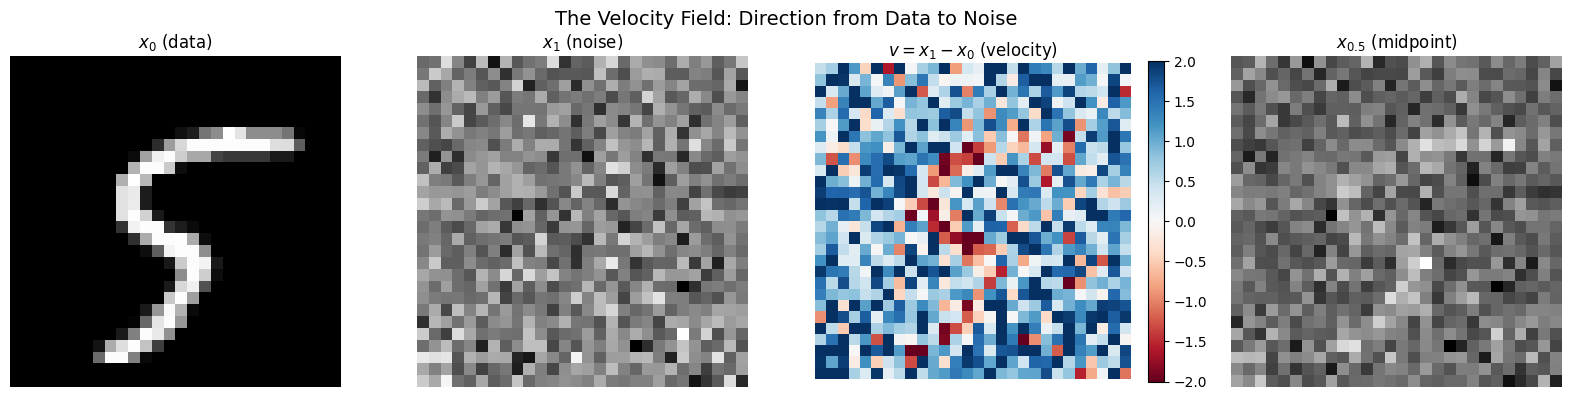


Interpreting the velocity:
• Red: noise brighter than data → positive velocity
• Blue: noise darker than data → negative velocity
• White: similar values → near-zero velocity


In [5]:
# Compute and visualize the velocity field for a single example
t_tensor = torch.tensor([0.5])  # Timestep doesn't matter for velocity!
x_t, velocity = flow.forward_process(x_0, x_1, t_tensor)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Data point x_0
axes[0].imshow((x_0[0, 0] + 1) / 2, cmap='gray')
axes[0].set_title('$x_0$ (data)', fontsize=12)
axes[0].axis('off')

# Noise point x_1
axes[1].imshow((x_1[0, 0] + 1) / 2, cmap='gray')
axes[1].set_title('$x_1$ (noise)', fontsize=12)
axes[1].axis('off')

# Velocity v = x_1 - x_0
v_display = velocity[0, 0].numpy()
im = axes[2].imshow(v_display, cmap='RdBu', vmin=-2, vmax=2)
axes[2].set_title('$v = x_1 - x_0$ (velocity)', fontsize=12)
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], fraction=0.046)

# Interpolated sample at t=0.5
axes[3].imshow((x_t[0, 0] + 1) / 2, cmap='gray')
axes[3].set_title('$x_{0.5}$ (midpoint)', fontsize=12)
axes[3].axis('off')

plt.suptitle('The Velocity Field: Direction from Data to Noise', fontsize=14)
plt.tight_layout()
plt.show()

print("\nInterpreting the velocity:")
print("• Red: noise brighter than data → positive velocity")
print("• Blue: noise darker than data → negative velocity")
print("• White: similar values → near-zero velocity")

In [6]:
# Verify: velocity is constant at all timesteps
print("Verifying that velocity is constant along the path...")
print()

for t in [0.0, 0.25, 0.5, 0.75, 1.0]:
    t_tensor = torch.tensor([t])
    _, v = flow.forward_process(x_0, x_1, t_tensor)
    v_norm = torch.norm(v).item()
    print(f"t = {t:.2f}: ||v|| = {v_norm:.4f}")

print()
print("✓ Velocity norm is identical at all timesteps!")
print("  This confirms v = x₁ - x₀ doesn't depend on t.")

Verifying that velocity is constant along the path...

t = 0.00: ||v|| = 39.2500
t = 0.25: ||v|| = 39.2500
t = 0.50: ||v|| = 39.2500
t = 0.75: ||v|| = 39.2500
t = 1.00: ||v|| = 39.2500

✓ Velocity norm is identical at all timesteps!
  This confirms v = x₁ - x₀ doesn't depend on t.


## Step 4: The Neural Network Architecture

We need a neural network $v_\theta(x_t, t)$ that:
- **Input**: Noised image $x_t$ (28×28×1) + timestep $t$ (scalar)
- **Output**: Predicted velocity $\hat{v}$ (28×28×1, same shape as input)

### U-Net: The Classic Choice

We use a **U-Net**, a proven architecture for image-to-image tasks:

```
Input (28×28) ──┐                      ┌── Output (28×28)
                ▼                      ▲
            [Encoder]              [Decoder]
                │                      │
           downsample              upsample
                │                      │
                ▼                      ▲
            (14×14)    ──────────>  (14×14)  ← skip connection
                │                      │
           downsample              upsample
                │                      │
                ▼                      ▲
             (7×7)     ──────────>   (7×7)   ← skip connection
                │                      │
                └─────> bottleneck ────┘
```

**Why U-Net?** The skip connections let fine-grained details flow directly to the output, while the bottleneck captures global context.

### Timestep Conditioning

The network needs to know the current timestep $t$. A scalar isn't expressive enough, so we use **sinusoidal positional encoding** (from the Transformer paper):

$$\text{emb}(t) = \left[\sin(\omega_1 t), \cos(\omega_1 t), \sin(\omega_2 t), \cos(\omega_2 t), \ldots\right]$$

where $\omega_i = 10000^{-2i/d}$ spans multiple frequencies. This rich embedding is projected and added to the network's feature maps at each layer.

In [7]:
from from_noise_to_images.models import SimpleUNet

model = SimpleUNet(
    in_channels=1,       # Grayscale images
    model_channels=64,   # Base channel count (doubled at each level)
    time_emb_dim=128,    # Timestep embedding dimension
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")
print(f"\nThis is relatively small - larger models give better quality.")

# Test forward pass
test_x = torch.randn(4, 1, 28, 28, device=device)
test_t = torch.rand(4, device=device)

with torch.no_grad():
    test_out = model(test_x, test_t)

print(f"\nForward pass test:")
print(f"  Input shape:  {test_x.shape}  (batch, channels, height, width)")
print(f"  Timestep:     {test_t.shape}  (batch,)")
print(f"  Output shape: {test_out.shape}  (same as input - velocity at each pixel)")

Model parameters: 1,837,185

This is relatively small - larger models give better quality.



Forward pass test:
  Input shape:  torch.Size([4, 1, 28, 28])  (batch, channels, height, width)
  Timestep:     torch.Size([4])  (batch,)
  Output shape: torch.Size([4, 1, 28, 28])  (same as input - velocity at each pixel)


## Step 5: Training the Velocity Predictor

### The Training Loop

For each training step:

1. **Sample data**: $x_0 \sim p_{\text{data}}$ (batch of real digits)
2. **Sample noise**: $x_1 \sim \mathcal{N}(0, I)$ (same shape as $x_0$)
3. **Sample timestep**: $t \sim \text{Uniform}[0, 1]$
4. **Compute interpolation**: $x_t = (1-t) x_0 + t x_1$
5. **Compute true velocity**: $v = x_1 - x_0$
6. **Predict velocity**: $\hat{v} = v_\theta(x_t, t)$
7. **Compute loss**: $\mathcal{L} = \|\hat{v} - v\|^2$ (MSE)
8. **Update weights**: Backprop and optimizer step

### Why Does This Work?

The model sees many triplets $(x_t, t) \to v$:
- Different data points $x_0$
- Different noise samples $x_1$
- Different timesteps $t$

It learns patterns like:
- "At $t \approx 1$ (mostly noise), velocities point toward structure"
- "At $t \approx 0$ (mostly data), velocities are small adjustments"

The key insight: by learning the **conditional expectation** of velocity given $x_t$ and $t$, the model implicitly learns the marginal distribution $p_t$ at each timestep.

(There's deep theory here connecting to optimal transport and continuity equations, but the practical algorithm is simple.)

In [8]:
from from_noise_to_images.train import Trainer

# Create trainer
trainer = Trainer(
    model=model,
    dataloader=train_loader,
    lr=1e-4,           # Learning rate
    weight_decay=0.01, # Regularization
    device=device,
)

# Train
NUM_EPOCHS = 30  # Increase to 50+ for better quality

print("Training the velocity prediction network...")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Batches per epoch: {len(train_loader)}")
print()

losses = trainer.train(num_epochs=NUM_EPOCHS)

Training the velocity prediction network...
Epochs: 30
Batch size: 128
Batches per epoch: 468

Training on cuda
Model parameters: 1,837,185


Epoch 1/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1: avg_loss = 0.3411


Epoch 2/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 2: avg_loss = 0.2256


Epoch 3/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 3: avg_loss = 0.2114


Epoch 4/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 4: avg_loss = 0.2029


Epoch 5/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 5: avg_loss = 0.1972


Epoch 6/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 6: avg_loss = 0.1937


Epoch 7/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 7: avg_loss = 0.1918


Epoch 8/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 8: avg_loss = 0.1882


Epoch 9/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 9: avg_loss = 0.1880


Epoch 10/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 10: avg_loss = 0.1845


Epoch 11/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 11: avg_loss = 0.1836


Epoch 12/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 12: avg_loss = 0.1838


Epoch 13/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 13: avg_loss = 0.1813


Epoch 14/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 14: avg_loss = 0.1808


Epoch 15/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 15: avg_loss = 0.1801


Epoch 16/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 16: avg_loss = 0.1793


Epoch 17/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 17: avg_loss = 0.1799


Epoch 18/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 18: avg_loss = 0.1785


Epoch 19/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 19: avg_loss = 0.1774


Epoch 20/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 20: avg_loss = 0.1767


Epoch 21/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 21: avg_loss = 0.1776


Epoch 22/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 22: avg_loss = 0.1768


Epoch 23/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 23: avg_loss = 0.1760


Epoch 24/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 24: avg_loss = 0.1754


Epoch 25/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 25: avg_loss = 0.1755


Epoch 26/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 26: avg_loss = 0.1753


Epoch 27/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 27: avg_loss = 0.1749


Epoch 28/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 28: avg_loss = 0.1748


Epoch 29/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 29: avg_loss = 0.1739


Epoch 30/30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 30: avg_loss = 0.1730


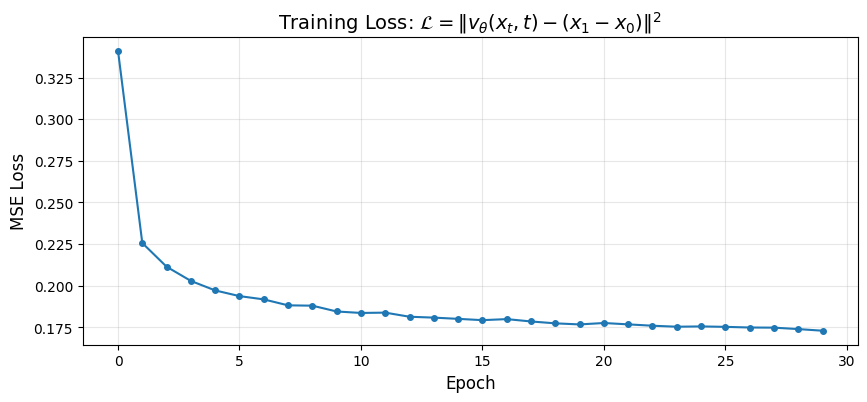

Final loss: 0.1730

Lower loss = better velocity predictions = better generation.


In [9]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses, marker='o', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title(r'Training Loss: $\mathcal{L} = \|v_\theta(x_t, t) - (x_1 - x_0)\|^2$', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {losses[-1]:.4f}")
print("\nLower loss = better velocity predictions = better generation.")

## Step 6: Generating New Images

- using our trained model to generate new digits from scratch!

### The Sampling ODE

We solve:
$$\frac{dx}{dt} = v_\theta(x, t)$$

**Starting point**: $x_1 \sim \mathcal{N}(0, I)$ (pure random noise at $t=1$)

**Goal**: Integrate backward to $t=0$ to get a sample from $p_{\text{data}}$

### Euler Integration

We discretize time into $N$ steps with $\Delta t = 1/N$:

$$x_{t - \Delta t} = x_t - \Delta t \cdot v_\theta(x_t, t)$$

At each step:
1. Ask the model: "What's the velocity at this point?"
2. Move in the *opposite* direction (we're going backward in time)
3. Repeat until we reach $t=0$

### Why Backward?

During training, velocities point from data to noise ($x_1 - x_0$).

During sampling, we want the reverse - from noise to data - so we:
- Start at $t=1$ (noise)
- Subtract the velocity (opposite direction)
- End at $t=0$ (data)

Generating 64 new digits from random noise...
(Starting at t=1, integrating backward to t=0)



Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

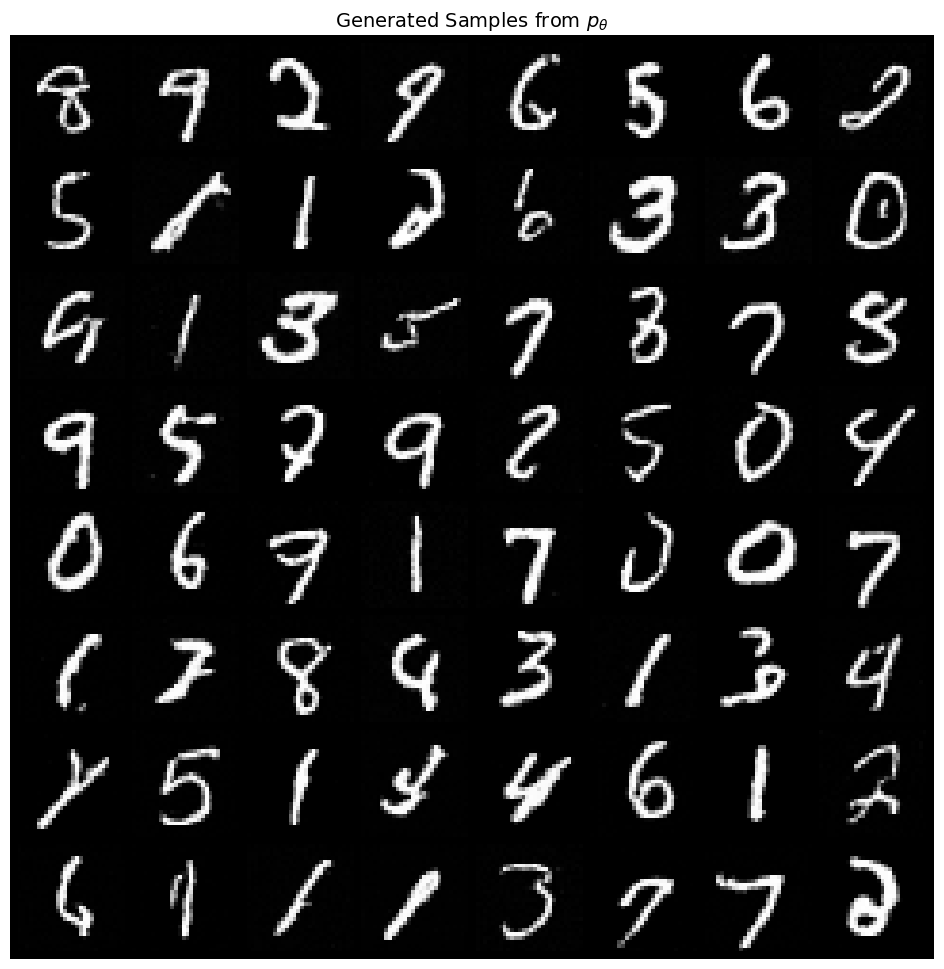

In [10]:
from from_noise_to_images.sampling import sample

# Generate samples
model.eval()

print("Generating 64 new digits from random noise...")
print("(Starting at t=1, integrating backward to t=0)")
print()

with torch.no_grad():
    generated, trajectory = sample(
        model=model,
        num_samples=64,
        image_shape=(1, 28, 28),
        num_steps=50,      # Number of Euler steps
        device=device,
        return_trajectory=True,
    )

show_images(generated, nrow=8, title="Generated Samples from $p_{\\theta}$")

## Step 7: Visualizing the Generation Process

Let's watch how noise transforms into digits step by step.

This shows the ODE integration in action:
- $t=1.00$: Pure noise $x_1 \sim \mathcal{N}(0, I)$
- $t \to 0$: Following $-v_\theta(x, t)$ backward
- $t=0.00$: Generated digit

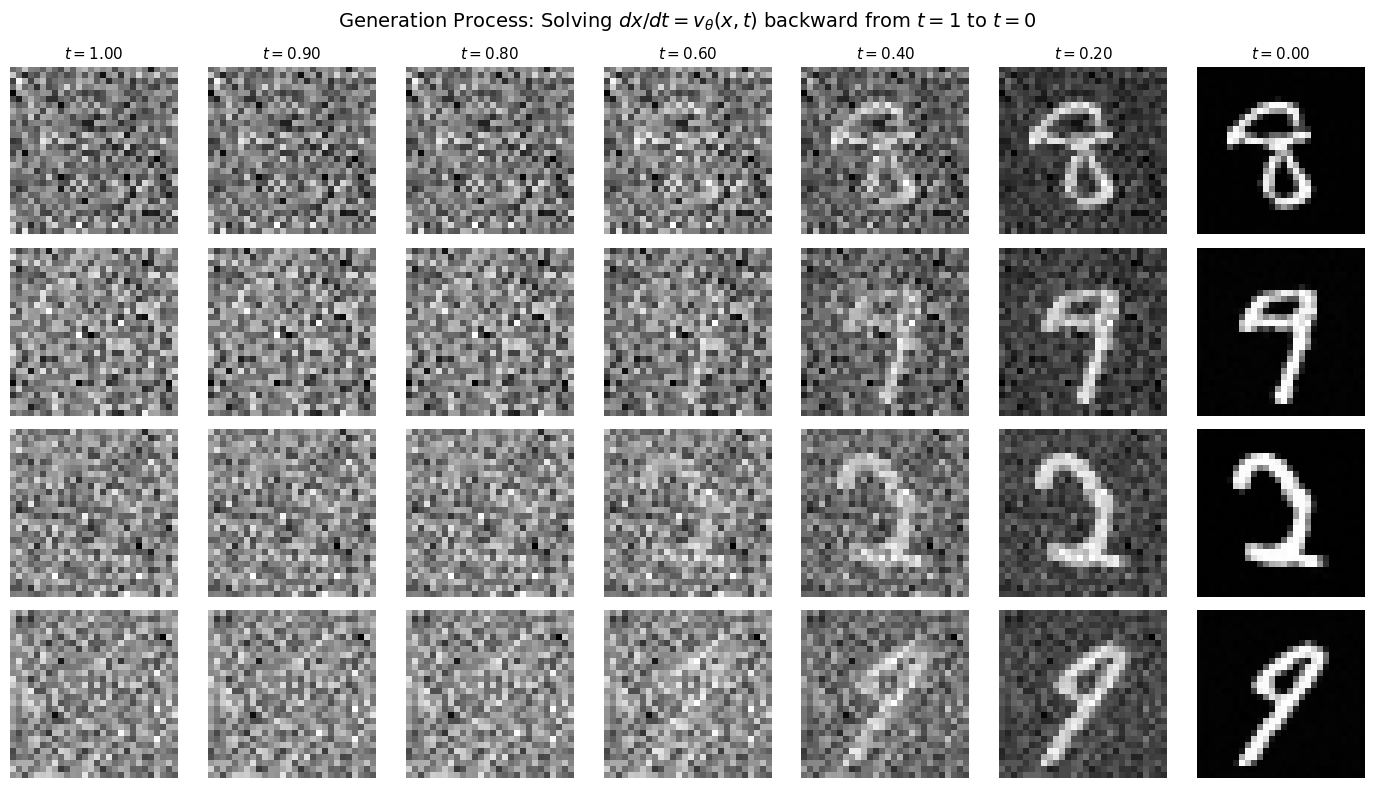


Watch how structure emerges:
• t≈1.0: Random noise (no discernible pattern)
• t≈0.6: Large-scale structure appears (rough digit shape)
• t≈0.3: Details emerge (strokes, curves)
• t=0.0: Final digit


In [11]:
# Show the trajectory for a few samples
num_to_show = 4
steps_to_show = [0, 5, 10, 20, 30, 40, 50]  # Which steps to visualize

fig, axes = plt.subplots(num_to_show, len(steps_to_show), figsize=(14, 8))

for row in range(num_to_show):
    for col, step_idx in enumerate(steps_to_show):
        img = trajectory[step_idx][row, 0]
        img = (img + 1) / 2  # Denormalize
        axes[row, col].imshow(img.cpu().numpy(), cmap='gray')
        axes[row, col].axis('off')
        if row == 0:
            t_val = 1.0 - step_idx / 50
            axes[row, col].set_title(f'$t={t_val:.2f}$', fontsize=11)

plt.suptitle('Generation Process: Solving $dx/dt = v_\\theta(x, t)$ backward from $t=1$ to $t=0$', fontsize=14)
plt.tight_layout()
plt.show()

print("\nWatch how structure emerges:")
print("• t≈1.0: Random noise (no discernible pattern)")
print("• t≈0.6: Large-scale structure appears (rough digit shape)")
print("• t≈0.3: Details emerge (strokes, curves)")
print("• t=0.0: Final digit")

## Step 8: Analyzing What the Model Learned

Let's examine how well the model predicts velocities. Remember: the model only sees $x_t$ and $t$, but must predict $v = x_1 - x_0$. It can't know the *exact* $x_1$ used (since that's random), so it learns to predict the *expected* velocity given the noisy input.

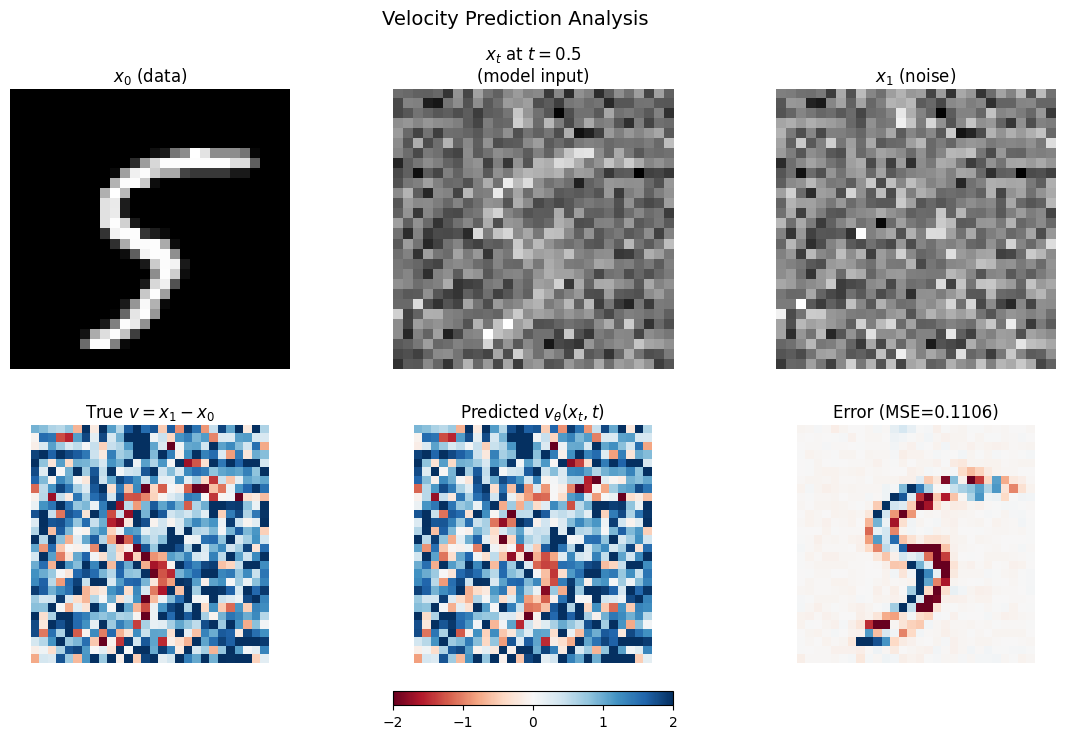


The model sees only x_t and t, but must predict v = x_1 - x_0.
It can't know the exact x_1 used, so it predicts the expected velocity.
The prediction captures overall structure even if not pixel-perfect.


In [12]:
# Compare predicted vs true velocity
x_0 = sample_batch[0:1].to(device)
x_1 = torch.randn_like(x_0)
t = torch.tensor([0.5], device=device)

# True velocity
true_v = x_1 - x_0

# Interpolated sample
x_t = (1 - t.view(-1, 1, 1, 1)) * x_0 + t.view(-1, 1, 1, 1) * x_1

# Predicted velocity
model.eval()
with torch.no_grad():
    pred_v = model(x_t, t)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Top row: the samples
axes[0, 0].imshow((x_0[0, 0].cpu() + 1) / 2, cmap='gray')
axes[0, 0].set_title('$x_0$ (data)', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow((x_t[0, 0].cpu() + 1) / 2, cmap='gray')
axes[0, 1].set_title('$x_t$ at $t=0.5$\n(model input)', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow((x_1[0, 0].cpu() + 1) / 2, cmap='gray')
axes[0, 2].set_title('$x_1$ (noise)', fontsize=12)
axes[0, 2].axis('off')

# Bottom row: velocities
vmin, vmax = -2, 2

im = axes[1, 0].imshow(true_v[0, 0].cpu(), cmap='RdBu', vmin=vmin, vmax=vmax)
axes[1, 0].set_title('True $v = x_1 - x_0$', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(pred_v[0, 0].cpu(), cmap='RdBu', vmin=vmin, vmax=vmax)
axes[1, 1].set_title('Predicted $v_\\theta(x_t, t)$', fontsize=12)
axes[1, 1].axis('off')

error = (pred_v - true_v)[0, 0].cpu()
axes[1, 2].imshow(error, cmap='RdBu', vmin=-1, vmax=1)
axes[1, 2].set_title(f'Error (MSE={torch.mean(error**2):.4f})', fontsize=12)
axes[1, 2].axis('off')

plt.colorbar(im, ax=axes[1, :], orientation='horizontal', fraction=0.05, pad=0.1)
plt.suptitle('Velocity Prediction Analysis', fontsize=14)
plt.show()

print("\nThe model sees only x_t and t, but must predict v = x_1 - x_0.")
print("It can't know the exact x_1 used, so it predicts the expected velocity.")
print("The prediction captures overall structure even if not pixel-perfect.")

In [13]:
# Save the trained model for use in the next notebook
trainer.save_checkpoint("phase1_model.pt")
print("Model saved to phase1_model.pt")

Model saved to phase1_model.pt


## Summary: The Flow Matching Recipe

We've built a complete generative model using flow matching. Here's the recipe:

### The Framework

| Step | What Happens |
|------|-------------|
| **1. Define the path** | Linear interpolation $x_t = (1-t)x_0 + tx_1$ |
| **2. Compute velocity** | Constant $v = x_1 - x_0$ |
| **3. Train** | Learn $v_\theta(x_t, t) \approx v$ via MSE |
| **4. Sample** | Solve ODE backward from $t=1$ to $t=0$ |

### Key Mathematical Insights

| Concept | Why It Matters |
|---------|---------------|
| **Linear interpolation** | Simplest path, constant velocity, optimal transport |
| **Constant velocity** | No acceleration = efficient integration |
| **MSE loss** | Directly measures velocity prediction quality |
| **Deterministic ODE** | Unlike DDPM, no stochastic noise during sampling |

### Limitations (So Far)

- **Unconditional**: We can't control which digit gets generated
- **CNN architecture**: U-Net works but doesn't scale as well as transformers
- **Small scale**: More training and larger models would help quality

## What's Next

In the following notebooks, we'll address these limitations:

**Notebook 02: Diffusion Transformer (DiT)**
- Replace the U-Net with a transformer
- Patchify images into sequences
- Use adaptive layer normalization (adaLN) for conditioning

**Notebook 03: Class Conditioning**
- Control which digit gets generated
- Classifier-free guidance for stronger conditioning

**Notebook 04: Text Conditioning**
- CLIP text encoder integration
- Cross-attention for text-to-image

**Notebook 05: Latent Diffusion**
- Work in compressed latent space
- VAE encoder/decoder
- The Stable Diffusion approach